In [6]:
%matplotlib inline
import sys, gc
sys.path.append('/home/igr/src/model/nengo_maze_env')
from functools import partial
import nengo
import numpy as np
import matplotlib.pyplot as plt
from prf_net import PRF
from ei_net import EI
from hsp import HSP
from isp import ISP
from tqdm import tqdm
import scipy.interpolate
from scipy.interpolate import Rbf, PchipInterpolator, Akima1DInterpolator
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance, sample_by_activity)
from nengo_extras.neurons import (
    rates_kernel, rates_isi, spikes2events )

In [7]:
def contiguous_ranges(input, return_indices=False):
    """Finds contiguous regions of the array "input". Returns
    a list of ranges with the start and end index of each region. Code based on:
    https://stackoverflow.com/questions/4494404/find-large-number-of-consecutive-values-fulfilling-condition-in-a-numpy-array/4495197
    """

    # Find the indices of changes in "condition"
    d = np.diff(input)
    nz, = d.nonzero() 

    print(nz)
    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the ranges by 1 to the right.
    nz += 1
    nz = np.concatenate([nz, [input.size]])
    
    ranges = np.vstack([ [nz[ri], nz[ri+1]] for ri in range(nz.size-1) ])
    ranges = np.vstack([[0, nz[0]], ranges])

    # Reshape the result into two columns
    ranges.shape = (-1,2)

    if return_indices:
        result = ( np.arange(*r) for r in ranges )
    else:
        result = ranges

    return result

In [8]:
dof_input_matrix = np.asarray(np.load("dof_array.npy"), dtype=np.float32)
print(dof_input_matrix.shape)
cnt_input_matrix = np.asarray(np.load("cnt_array.npy"), dtype=np.float32)
print(cnt_input_matrix.shape)

(4096, 1771)
(4096, 1771)


In [9]:
n_steps = 100
n_trials = 3
input_matrix = np.vstack((dof_input_matrix, cnt_input_matrix))
normed_input_matrix = input_matrix / np.max(input_matrix)
train_data = np.tile(np.repeat(normed_input_matrix[:,:30], n_steps, axis=1), (1, n_trials))
print(train_data.shape)
print(np.max(train_data))
np.save("srf_nengo_dof_input_matrix.npy", train_data)

(8192, 9000)
0.764977


In [10]:
def array_input(input_matrix, dt, t, *args):
    i = int(t/dt)
    if i >= input_matrix.shape[1]:
        i = -1
    return input_matrix[:,i]

In [12]:
N_inputs = train_data.shape[0]

N_outputs_srf = 1000
N_exc_srf = N_inputs
N_inh_srf = int(N_outputs_srf/4)


N_exc_place = 1000
N_inh_place = int(N_exc_place/4)

dt = 0.001
srf_seed = 19
t_end = train_data.shape[1] * dt
print(f't_end = {t_end}')


srf_place_network = nengo.Network(label="Learning with spatial receptive fields", seed=srf_seed)
rng = np.random.RandomState(seed=srf_seed)



params = {'w_initial_E': 0.0817, 
          'w_initial_EI': 0.00146, 
          'w_initial_I': -0.0355, 
          'w_EI_Ext': 0.0058, 
          'w_PV_E': 0.015, 
          'w_SV_E': 0.065, 
          'w_PV_I': 0.044, 
          'p_E_srf': 0.02, 
          'p_EE': 0.01, 
          'p_EI': 0.1,
          'p_EI_Ext': 0.007, 
          'p_PV_E': 0.004, 
          'p_SV_E': 0.003, 
          'tau_E': 0.005, 
          'tau_I': 0.020, 
          'learning_rate_I': 0.01, 
          'learning_rate_E': 0.05}




with srf_place_network as model:
    
    
    srf_network = PRF(exc_input_func=partial(array_input, train_data, dt),
                      connect_exc_inh_input = True,
                      n_excitatory = N_exc_srf,
                      n_inhibitory = N_inh_srf,
                      n_outputs = N_outputs_srf,
                      isp_target_rate = 1.0,
                      tau_input = 0.1,

                      w_initial_E = params['w_initial_E'],
                      w_initial_I = params['w_initial_I'],
                      w_initial_EI = params['w_initial_EI'],
                      w_EI_Ext = params['w_EI_Ext'],
                      p_E = params['p_E_srf'],
                      p_EE = params['p_EE'],
                      p_EI_Ext = params['p_EI_Ext'],
                      p_EI = params['p_EI'],
                      tau_E = params['tau_E'],
                      tau_I = params['tau_I'],
                      learning_rate_I=params['learning_rate_I'],
                      learning_rate_E=params['learning_rate_E'],
               
                      label="Spatial receptive field network",
                      seed=srf_seed)
 
    
    place_network = EI(n_excitatory = N_exc_place,
                    n_inhibitory = N_inh_place,
                    connect_exc_inh = True,
                    isp_target_rate = 1.0,
                    tau_input = 0.1,
                    learning_rate_I=params['learning_rate_I'],
                    learning_rate_E=params['learning_rate_E'],
                    p_EE = params['p_EE'],
                    p_EI = params['p_EI'],
                    tau_E = params['tau_E'], 
                    tau_I = params['tau_I'],
                    label="Place network",
                    seed=srf_seed)

    w_PV_E = params['w_PV_E']
    p_PV_E = params['p_PV_E']
    weights_dist_PV_E = rng.normal(size=N_outputs_srf*N_exc_place).reshape((N_exc_place, N_outputs_srf))
    weights_initial_PV_E = (weights_dist_PV_E - weights_dist_PV_E.min()) / (weights_dist_PV_E.max() - weights_dist_PV_E.min()) * w_PV_E
    for i in range(N_exc_place):
        dist = i - np.asarray(range(N_outputs_srf))                                                          
        sigma = p_PV_E * N_outputs_srf                                                                      
        weights = np.exp(-dist/sigma**2)                                                                    
        prob = weights / weights.sum(axis=0)                                                                
        sources = np.asarray(rng.choice(N_outputs_srf, round(p_PV_E * N_outputs_srf), replace=False, p=prob), dtype=np.int32)
        weights_initial_PV_E[i, np.logical_not(np.in1d(range(N_outputs_srf), sources))] = 0.

    conn_PV_E = nengo.Connection(srf_network.output.neurons,
                             place_network.exc.neurons,
                             transform=weights_initial_PV_E,
                             synapse=nengo.Alpha(params['tau_E']),
                             learning_rule_type=HSP(learning_rate=params['learning_rate_E']))

    w_SV_E = params['w_PV_E']
    p_SV_E = params['p_SV_E']
    weights_dist_SV_E = rng.normal(size=N_exc_srf*N_exc_place).reshape((N_exc_place, N_exc_srf))
    weights_initial_SV_E = (weights_dist_SV_E - weights_dist_SV_E.min()) / (weights_dist_SV_E.max() - weights_dist_SV_E.min()) * w_SV_E
    for i in range(N_exc_place):
        dist = i - np.asarray(range(N_exc_srf))                                                          
        sigma = p_SV_E * N_exc_srf                                                                      
        weights = np.exp(-dist/sigma**2)                                                                    
        prob = weights / weights.sum(axis=0)                                                                
        sources = np.asarray(rng.choice(N_exc_srf, round(p_SV_E * N_exc_srf), replace=False, p=prob), dtype=np.int32)
        weights_initial_SV_E[i, np.logical_not(np.in1d(range(N_exc_srf), sources))] = 0.
    conn_SV_E = nengo.Connection(srf_network.exc.neurons,
                             place_network.exc.neurons,
                             transform=weights_initial_SV_E,
                             synapse=nengo.Alpha(params['tau_E']),
                             learning_rule_type=HSP(learning_rate=params['learning_rate_E']))

    w_PV_I = params['w_PV_I']
    weights_initial_PV_I = rng.uniform(size=N_inh_place*N_outputs_srf).reshape((N_inh_place, N_outputs_srf)) * w_PV_I
    conn_PV_I = nengo.Connection(srf_network.output.neurons,
                             place_network.inh.neurons,
                             transform=weights_initial_PV_I,
                             synapse=nengo.Alpha(params['tau_E']))
 
       
    with place_network:
        p_place_output_spikes = nengo.Probe(place_network.exc.neurons, synapse=None)
        p_place_inh_rates = nengo.Probe(place_network.inh.neurons)
        
    with srf_network:
        p_output_spikes = nengo.Probe(srf_network.output.neurons, synapse=None)
        p_exc_rates = nengo.Probe(srf_network.exc.neurons)
        p_inh_rates = nengo.Probe(srf_network.inh.neurons)
        p_inh_weights = nengo.Probe(srf_network.conn_I, 'weights', sample_every=3.0)
        p_exc_weights = nengo.Probe(srf_network.conn_E, 'weights', sample_every=3.0)
        if srf_network.conn_EE is not None:
            p_rec_weights = nengo.Probe(srf_network.conn_EE, 'weights', sample_every=3.0)

    p_weights_PV_E = nengo.Probe(conn_PV_E, 'weights', sample_every=3.0)
    p_weights_PV_E = nengo.Probe(conn_PV_I, 'weights', sample_every=3.0)


t_end = 9.0


In [13]:
        
with nengo.Simulator(model, optimize=True) as sim:
    sim.run(np.max(t_end))
    


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/igr/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


In [15]:
output_spikes = sim.data[p_output_spikes]
exc_rates = sim.data[p_exc_rates]
inh_rates = sim.data[p_inh_rates] 
#exc_weights = sim.data[p_exc_weights]
#inh_weights = sim.data[p_inh_weights] 


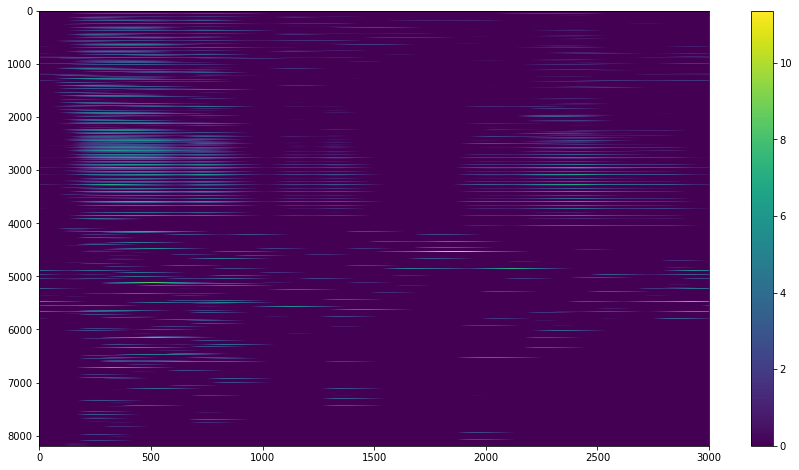

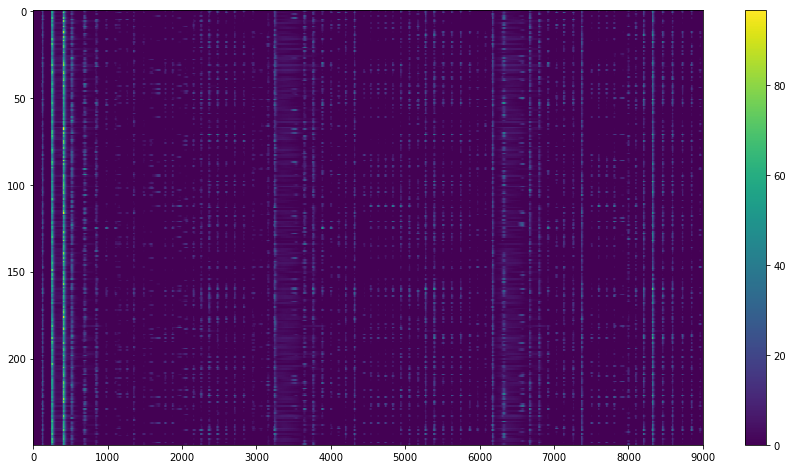

In [16]:
plt.figure(figsize=(15,8))
plt.imshow(exc_rates[6000:,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();

plt.figure(figsize=(15,8))
plt.imshow(inh_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();


0.8238686213546743


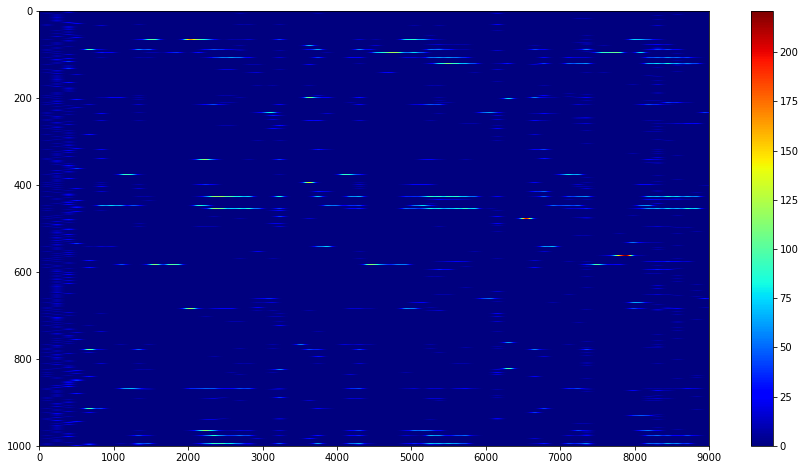

In [17]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
#output_rates = rates_isi(sim.trange(), output_spikes)
plt.figure(figsize=(15,8))
plt.imshow(output_rates.T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(output_rates))


0.8238686213546743


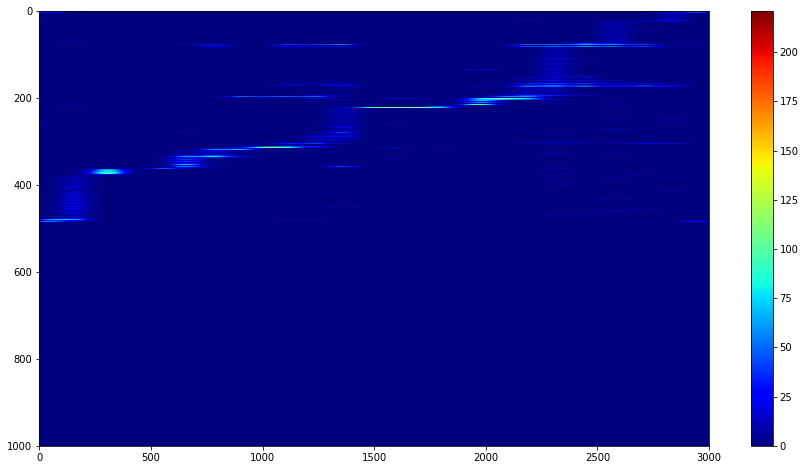

In [18]:
# output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(output_rates[6000:].T, axis=1))
plt.imshow(output_rates[6000:,sorted_idxs].T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(output_rates))


0.8238686213546743


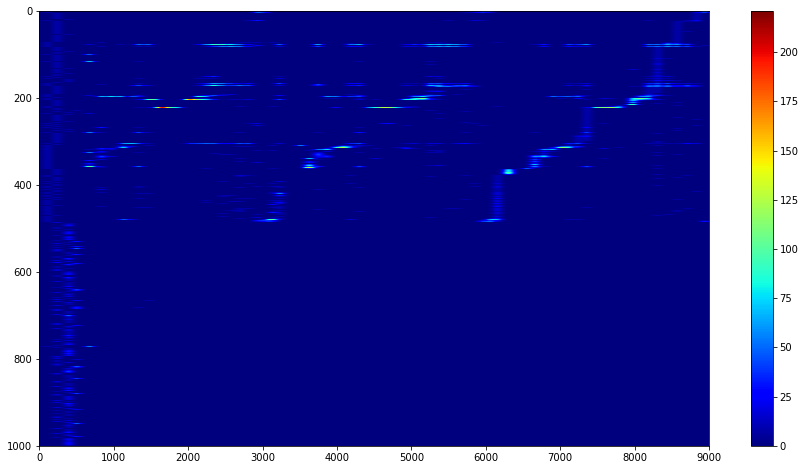

In [19]:
# output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(output_rates[6000:].T, axis=1))
plt.imshow(output_rates[:,sorted_idxs].T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(output_rates))


0.18343281807150874


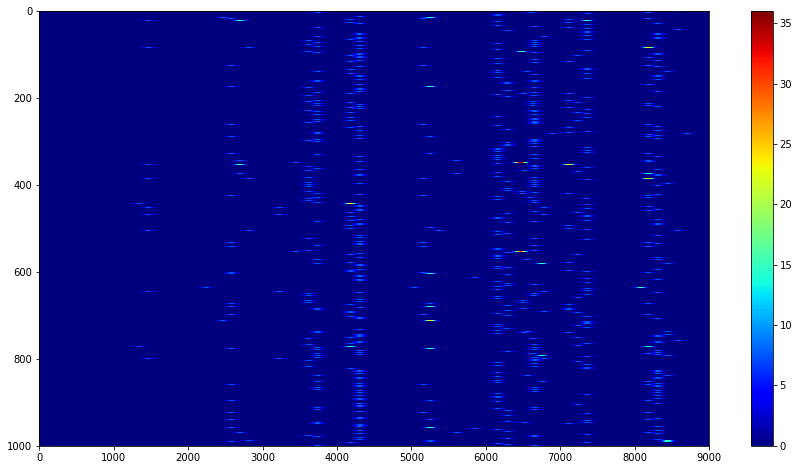

In [20]:
place_spikes = sim.data[p_place_output_spikes]
place_rates = rates_kernel(sim.trange(), place_spikes, tau=0.1)
plt.figure(figsize=(15,8))
plt.imshow(place_rates.T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(place_rates))


0.18343281807150874


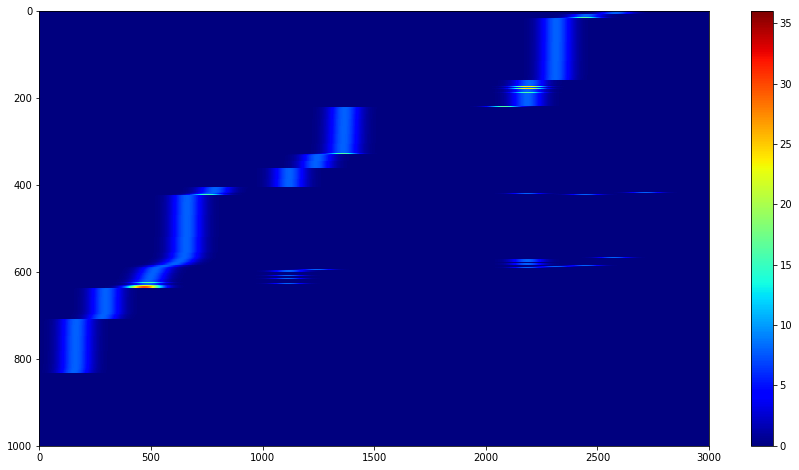

In [21]:
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(place_rates[6000:].T, axis=1))
plt.imshow(place_rates[6000:,sorted_idxs].T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(place_rates))


804.0209735571289


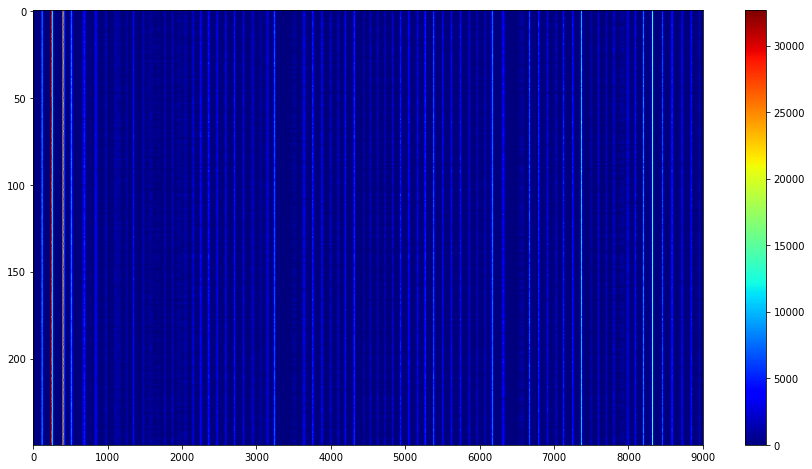

In [22]:

place_inh_rates = sim.data[p_place_inh_rates]
plt.figure(figsize=(15,8))
plt.imshow(place_inh_rates.T, interpolation="nearest", aspect="auto", cmap="jet")
plt.colorbar();
print(np.mean(place_inh_rates))
